In [1]:
import tensorflow_datasets as tfds
# Download the subword encoded pretokenized dataset
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
# Get the tokenizer
tokenizer = info.features['text'].encoder

2022-09-17 14:30:57.822711: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 14:30:57.917326: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 14:30:57.919509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 14:30:57.924187: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [2]:
BUFFER_SIZE = 10000
BATCH_SIZE = 256  #increase batch size to train faster

# Get the train and test splits
train_data, test_data = dataset['train'], dataset['test'], 

# Shuffle the training data
train_dataset = train_data.shuffle(BUFFER_SIZE)

# Batch and pad the datasets to the maximum length of the sequences
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
test_dataset = test_data.padded_batch(BATCH_SIZE)

#### Build and compile model

To build mutiple LSTM, add another LSTM layer in the Sequential model and enable `return_sequence` to `True`


In [3]:
import tensorflow as tf
import numpy as np

# Hyperparameters
batch_size = 1
timesteps = 20
features = 16
lstm_dim = 8

print(f'batch_size: {batch_size}')
print(f'timesteps (sequence length): {timesteps}')
print(f'features (embedding size): {features}')
print(f'lstm output units: {lstm_dim}')

# Define array input with random values
random_input = np.random.rand(batch_size,timesteps,features)
print(f'shape of input array: {random_input.shape}')

# Define LSTM that returns a single output
lstm = tf.keras.layers.LSTM(lstm_dim)
result = lstm(random_input)
print(f'shape of lstm output(return_sequences=False): {result.shape}')

# Define LSTM that returns a sequence
lstm_rs = tf.keras.layers.LSTM(lstm_dim, return_sequences=True)
result = lstm_rs(random_input)
print(f'shape of lstm output(return_sequences=True): {result.shape}')

batch_size: 1
timesteps (sequence length): 20
features (embedding size): 16
lstm output units: 8
shape of input array: (1, 20, 16)


2022-09-17 14:54:21.924596: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


shape of lstm output(return_sequences=False): (1, 8)
shape of lstm output(return_sequences=True): (1, 20, 8)


In [4]:
import tensorflow as tf

# Hyperparameters
embedding_dim = 64
lstm1_dim = 64
lstm2_dim = 32
dense_dim = 64

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1_dim, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm2_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          523840    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 635,329
Trainable params: 635,329
Non-trai

In [5]:
# Set the training parameters
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
NUM_EPOCHS = 10

# Train the model
history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Epoch 1/10


2022-09-17 14:55:30.048989: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


98/98 [==============================] - 33s 287ms/step - loss: 0.5448 - accuracy: 0.6975 - val_loss: 0.4183 - val_accuracy: 0.8190
Epoch 2/10
98/98 [==============================] - 27s 278ms/step - loss: 0.3142 - accuracy: 0.8759 - val_loss: 0.3634 - val_accuracy: 0.8578
Epoch 3/10
98/98 [==============================] - 27s 281ms/step - loss: 0.2267 - accuracy: 0.9187 - val_loss: 0.3776 - val_accuracy: 0.8460
Epoch 4/10
98/98 [==============================] - 27s 279ms/step - loss: 0.1972 - accuracy: 0.9281 - val_loss: 0.4016 - val_accuracy: 0.8271
Epoch 5/10
98/98 [==============================] - 27s 281ms/step - loss: 0.1450 - accuracy: 0.9506 - val_loss: 0.4926 - val_accuracy: 0.8358
Epoch 6/10
98/98 [==============================] - 27s 281ms/step - loss: 0.1151 - accuracy: 0.9626 - val_loss: 0.5120 - val_accuracy: 0.8199
Epoch 7/10
98/98 [==============================] - 28s 282ms/step - loss: 0.1210 - accuracy: 0.9600 - val_loss: 0.5647 - val_accuracy: 0.8325
Epoch 8/10

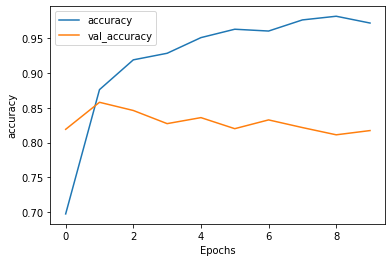

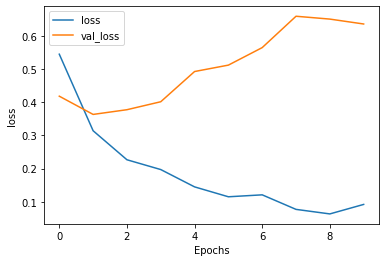

In [7]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# Plot the accuracy and results 
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")